In [7]:
%matplotlib inline
from preamble import *

# 第7章 处理文本数据

## 7.1 用字符串表示的数据类型

## 7.2 示例：电影评论的情感分析
    作为一个运行示例，我们将使用由斯坦福研究员Andrew Maas 收集的IMDb（Internet Movie Database，互联网电影数据库）网站的电影评论数据集。4 这个数据集包含评论文本，还有一个标签，用于表示该评论是“正面的”（positive）还是“负面的”（negative）。IMDb 网站本身包含从1 到10 的打分。为了简化建模，这些评论打分被归纳为一个二分类数据集，评分大于等于7 的评论被标记为“正面的”，评分小于等于4 的评论被标记为“负面的”，中性评论没有包含在数据集中。我们不讨论这种方法是否是一种好的数据表示，而只是使用Andrew Maas 提供的数据。
    将数据解压之后，数据集包括两个独立文件夹中的文本文件，一个是训练数据，一个是测试数据。每个文件夹又都有两个子文件夹，一个叫作pos，一个叫作neg：

In [8]:
!tree data/aclImdb

文件夹 PATH 列表
卷序列号为 CE2F-63AD
C:\USERS\ADMINISTRATOR\《PYTHON 机器学习基础教程》学习笔记\DATA\ACLIMDB
├─test
│  ├─neg
│  └─pos
└─train
    ├─neg
    └─pos


    pos 文件夹包含所有正面的评论，每条评论都是一个单独的文本文件，neg 文件夹与之类似。scikit-learn 中有一个辅助函数可以加载用这种文件夹结构保存的文件，其中每个子文件夹对应于一个标签，这个函数叫作load_files。我们首先将load_files 函数应用于训练数据：

In [9]:
from sklearn.datasets import load_files
reviews_train = load_files("data/aclImdb/train")
# load_files返回一个Bunch对象，其中包含训练文本和训练标签
text_train,y_train = reviews_train.data,reviews_train.target
print("type of text_train:{}",type(text_train))
print("length of text_train:",len(text_train))
print("text_train[1]:\n",text_train[1])

type of text_train:{} <class 'list'>
length of text_train: 25000
text_train[1]:
 b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Deci

    你可以看到，text_train 是一个长度为25 000 的列表6，其中每个元素是包含一条评论的字符串。我们打印出索引编号为1 的评论。你还可以看到，评论中包含一些HTML 换行符（<br />）。虽然这些符号不太可能对机器学习模型产生很大影响，但最好在继续下一步之前清洗数据并删除这种格式：

In [10]:
text_train = [doc.replace(b"<br />",b" ") for doc in text_train]

In [11]:
#收集数据集时保持正类和反类的平衡，这样所有正面字符串和负面字符串的数量相等：
print("Samples per class (training):",np.bincount(y_train))

Samples per class (training): [12500 12500]


In [12]:
#用同样的方式加载测试数据集：
reviews_test = load_files("data/aclImdb/test")
text_test,y_test = reviews_test.data,reviews_test.target
print("Number of documents in test data:",len(text_test))
print("Samples per class (test):",np.bincount(y_test))
text_test = [doc.replace(b"<br />",b" ") for doc in text_test]

Number of documents in test data: 25000
Samples per class (test): [12500 12500]


# 7.3 将文本数据表示为词袋
    用于机器学习的文本表示有一种最简单的方法，也是最有效且最常用的方法，就是使用词袋（bag-of-words）表示。使用这种表示方式时，我们舍弃了输入文本中的大部分结构，如章节、段落、句子和格式，只计算语料库中每个单词在每个文本中的出现频次。舍弃结构并仅计算单词出现次数，这会让脑海中出现将文本表示为“袋”的画面。
    对于文档语料库，计算词袋表示包括以下三个步骤。
    (1) 分词（tokenization）。将每个文档划分为出现在其中的单词[ 称为词例（token）]，比如按空格和标点划分。
    (2) 构建词表（vocabulary building）。收集一个词表，里面包含出现在任意文档中的所有词，并对它们进行编号（比如按字母顺序排序）。
    (3) 编码（encoding）。对于每个文档，计算词表中每个单词在该文档中的出现频次。
    在步骤1 和步骤2 中涉及一些细微之处，我们将在本章后面进一步深入讨论。目前，我们来看一下如何利用scikit-learn 来应用词袋处理过程。图7-1 展示了对字符串"This ishow you get ants." 的处理过程。其输出是包含每个文档中单词计数的一个向量。对于词表中的每个单词，我们都有它在每个文档中的出现次数。也就是说，整个数据集中的每个唯一单词都对应于这种数值表示的一个特征。请注意，原始字符串中的单词顺序与词袋特征表示完全无关。

![bag_of_words](images/bag_of_words.png)
<br/><center><font size="5">图7-1 词袋处理过程</font></center>

## 7.3.1 将词袋应用于玩具数据集
    词袋表示是在CountVectorizer 中实现的，它是一个变换器（transformer）。我们首先将它应用于一个包含两个样本的玩具数据集，来看一下它的工作原理：

In [13]:
bards_words = ["The fool doth think he is wise,","but the wise man knows himself to be a fool"]

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(bards_words)
#拟合CountVectorizer 包括训练数据的分词与词表的构建，
#我们可以通过vocabulary_ 属性来访问词表：
print("Vocabulary size:",len(vect.vocabulary_))
print("Vocabulary content:\n",vect.vocabulary_)

Vocabulary size: 13
Vocabulary content:
 {'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


In [15]:
#词表共包含13 个词，从"be" 到"wise"。
#我们可以调用transform 方法来创建训练数据的词袋表示：
bag_of_words = vect.transform(bards_words)
print("bag_of_words:",repr(bag_of_words))

bag_of_words: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


In [16]:
print("Dense representation of bag_of_words:\n",bag_of_words.toarray())

Dense representation of bag_of_words:
 [[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


    词袋表示保存在一个矩阵中，矩阵的形状为2×13，每行对应于两个数据点之一，每个特征对应于词表中的一个单词。这里使用稀疏矩阵，是因为大多数文档都只包含词表中的一小部分单词，也就是说，特征数组中的大部分元素都为0。要想查看矩阵的实际内容，可以使用toarray 方法将其转换为NumPy 数组。
    我们可以看到，每个单词的计数都是0 或1。bards_words 中的两个字符串都没有包含相同的单词。我们来看一下如何阅读这些特征向量。第一个字符串（"The fool doth think heis wise,"）被表示为第一行，对于词表中的第一个单词"be"，出现0 次。对于词表中的第二个单词"but"，出现0 次。对于词表中的第三个单词"doth"，出现1 次，以此类推。通过观察这两行可以看出，第4 个单词"fool"、第10 个单词"the" 与第13 个单词"wise" 同时出现在两个字符串中。

# 7.3.2 将词袋应用于电影评论
    上一节我们详细介绍了词袋处理过程，下面我们将其应用于电影评论情感分析的任务。前面我们将IMDb 评论的训练数据和测试数据加载为字符串列表（text_train 和text_test），现在我们将处理它们：

In [17]:
vect = CountVectorizer().fit(text_train)
x_train = vect.transform(text_train)
print("x_train:",repr(x_train))

x_train: <25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>


    x_train 是训练数据的词袋表示，其形状为25 000×74 849，这表示词表中包含74 849 个元素。数据同样被保存为SciPy 稀疏矩阵。我们来更详细地看一下这个词表。访问词表的另一种方法是使用向量器（vectorizer）的get_feature_name 方法，它将返回一个列表，每个元素对应于一个特征：

In [18]:
feature_names = vect.get_feature_names()
print("Number of features:",len(feature_names))
print("First 20 features:\n",feature_names[:20])
print("Features 20010 to 20030:\n",feature_names[20010:20030])
print("Every 2000th features:\n",feature_names[::2000])

Number of features: 74849
First 20 features:
 ['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02']
Features 20010 to 20030:
 ['dratted', 'draub', 'draught', 'draughts', 'draughtswoman', 'draw', 'drawback', 'drawbacks', 'drawer', 'drawers', 'drawing', 'drawings', 'drawl', 'drawled', 'drawling', 'drawn', 'draws', 'draza', 'dre', 'drea']
Every 2000th features:
 ['00', 'aesir', 'aquarian', 'barking', 'blustering', 'bête', 'chicanery', 'condensing', 'cunning', 'detox', 'draper', 'enshrined', 'favorit', 'freezer', 'goldman', 'hasan', 'huitieme', 'intelligible', 'kantrowitz', 'lawful', 'maars', 'megalunged', 'mostey', 'norrland', 'padilla', 'pincher', 'promisingly', 'receptionist', 'rivals', 'schnaas', 'shunning', 'sparse', 'subset', 'temptations', 'treatises', 'unproven', 'walkman', 'xylophonist']


    如你所见，词表的前10 个元素都是数字，所有这些数字都出现在评论中的某处，因此被提取为单词。大部分数字都没有一目了然的语义，除了"007"，在电影的特定语境中它可能指的是詹姆斯• 邦德（James Bond）这个角色。8 从无意义的“单词”中挑出有意义的有时很困难。进一步观察这个词表，我们发现许多以“dra”开头的英语单词。你可能注意到了，对于"draught"、"drawback" 和"drawer"，其单数和复数形式都包含在词表中，并且作为不同的单词。这些单词具有密切相关的语义，将它们作为不同的单词进行计数（对应于不同的特征）可能不太合适。
    在尝试改进特征提取之前，我们先通过实际构建一个分类器来得到性能的量化度量。我们将训练标签保存在y_train 中，训练数据的词袋表示保存在x_train 中，因此我们可以在这个数据上训练一个分类器。对于这样的高维稀疏数据，类似LogisticRegression 的线性模型通常效果最好。
    我们首先使用交叉验证对LogisticRegression 进行评估：

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
scores = cross_val_score(LogisticRegression(),x_train,y_train,cv=5)
print("Mean cross-validation accuracy:",np.mean(scores))

Mean cross-validation accuracy: 0.88128


In [20]:
#得到的交叉验证平均分数是88%，这对于平衡的二分类任务来说是一个合理的性能。
#LogisticRegression 有一个正则化参数C，可以通过交叉验证来调节它：
from sklearn.model_selection import GridSearchCV
param_grid = {'C':[0.001,0.01,0.1,1,10]}
grid = GridSearchCV(LogisticRegression(),param_grid,cv=5)
grid.fit(x_train,y_train)
print("Best cross-validation score:",grid.best_score_)
print("Best parameters:",grid.best_params_)

Best cross-validation score: 0.88816
Best parameters: {'C': 0.1}


In [21]:
#我们使用C=0.1 得到的交叉验证分数是89%。在测试集上评估这个参数设置的泛化性能：
x_test = vect.transform(text_test)
print("{:.2f}".format(grid.score(x_test, y_test)))

0.88


        下面我们来看一下能否改进单词提取。CountVectorizer 使用正则表达式提取词例。默认使用的正则表达式是"\b\w\w+\b"。如果你不熟悉正则表达式，它的含义是找到所有包含至少两个字母或数字（\w）且被词边界（\b）分隔的字符序列。它不会匹配只有一个字母的单词，还会将类似“doesn't”或“bit.ly”之类的缩写分开，但它会将“h8ter”匹配为一个单词。然后，CountVectorizer 将所有单词转换为小写字母，这样“soon”“Soon”和“sOon”都对应于同一个词例（因此也对应于同一个特征）。这一简单机制在实践中的效果很好，但正如前面所见，我们得到了许多不包含信息量的特征（比如数字）。减少这种特征的一种方法是，仅使用至少在2 个文档（或者至少5 个，等等）中出现过的词例。仅在一个文档中出现的词例不太可能出现在测试集中，因此没什么用。我们可以用min_df 参数来设置词例至少需要在多少个文档中出现过：

In [29]:
vect = CountVectorizer(min_df=5).fit(text_train)
x_train = vect.transform(text_train)
print("x_train with min_df:",repr(x_train))

x_train with min_df: <25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>


    通过要求每个词例至少在5 个文档中出现过，我们可以将特征数量减少到27 271 个，正如上面的输出所示——只有原始特征的三分之一左右。我们再来查看一些词例：

In [31]:
feature_names = vect.get_feature_names()
print("Number of features:",len(feature_names))
print("First 50 features:\n",feature_names[:50])
print("Features 20010 to 20030:\n",feature_names[20010:20030])
print("Every 700th features:\n",feature_names[::700])

Number of features: 27271
First 50 features:
 ['00', '000', '007', '00s', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '100th', '101', '102', '103', '104', '105', '107', '108', '10s', '10th', '11', '110', '112', '116', '117', '11th', '12', '120', '12th', '13', '135', '13th', '14', '140', '14th', '15', '150', '15th', '16', '160', '1600', '16mm', '16s', '16th']
Features 20010 to 20030:
 ['repentance', 'repercussions', 'repertoire', 'repetition', 'repetitions', 'repetitious', 'repetitive', 'rephrase', 'replace', 'replaced', 'replacement', 'replaces', 'replacing', 'replay', 'replayable', 'replayed', 'replaying', 'replays', 'replete', 'replica']
Every 700th features:
 ['00', 'affections', 'appropriately', 'barbra', 'blurbs', 'butchered', 'cheese', 'commitment', 'courts', 'deconstructed', 'disgraceful', 'dvds', 'eschews', 'fell', 'freezer', 'goriest', 'hauser', 'hungary', 'insinuate', 'juggle', 'leering', 'maelstrom', 'messiah', 'music', 'occasional', 'parking',

    网格搜索的最佳验证精度还是89%，这和前面一样。我们并没有改进模型，但减少要处理的特征数量可以加速处理过程，舍弃无用的特征也可能提高模型的可解释性。

In [32]:
grid = GridSearchCV(LogisticRegression(),param_grid,cv=5)
grid.fit(x_train,y_train)
print("Best cross-validation score:",grid.best_score_)

Best cross-validation score: 0.88812


# 7.4 停用词
    删除没有信息量的单词还有另一种方法，就是舍弃那些出现次数太多以至于没有信息量的单词。有两种主要方法：使用特定语言的停用词（stopword）列表，或者舍弃那些出现过于频繁的单词。scikit-learn 的feature_extraction.text 模块中提供了英语停用词的内置列表：

In [35]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print("Number of stop words:",len(ENGLISH_STOP_WORDS))
print("Every 10th stopword:\n", list(ENGLISH_STOP_WORDS)[::10])

Number of stop words: 318
Every 10th stopword:
 ['show', 'another', 'whence', 'neither', 'their', 'up', 'until', 'beside', 'whatever', 'also', 'more', 'yourself', 'beyond', 'once', 'last', 'nowhere', 'rather', 'both', 'below', 'through', 'wherein', 'name', 'detail', 'from', 'former', 'if', 'own', 'have', 'full', 'am', 'becoming', 'anyway']


    显然，删除上述列表中的停用词只能使特征数量减少318 个（即上述列表的长度），但可能会提高性能。我们来试一下：

In [36]:
# 指定stop_words="english"将使用内置列表。
# 我们也可以扩展这个列表并传入我们自己的列表。
vect = CountVectorizer(min_df=5,stop_words='english').fit(text_train)
x_train = vect.transform(text_train)
print("x_train with stop words:\n",repr(x_train))

x_train with stop words:
 <25000x26966 sparse matrix of type '<class 'numpy.int64'>'
	with 2149958 stored elements in Compressed Sparse Row format>


    现在数据集中的特征数量减少了305 个（27271-26966），说明大部分停用词（但不是所有）都出现了。我们再次运行网格搜索：

In [37]:
grid = GridSearchCV(LogisticRegression(),param_grid,cv=5)
grid.fit(x_train,y_train)
print("Best cross-validation score:",grid.best_score_)

Best cross-validation score: 0.88292


    使用停用词后的网格搜索性能略有下降——不至于担心，但鉴于从27 000 多个特征中删除305 个不太可能对性能或可解释性造成很大影响，所以使用这个列表似乎是不值得的。固定的列表主要对小型数据集很有帮助，这些数据集可能没有包含足够的信息，模型从数据本身无法判断出哪些单词是停用词。作为练习，你可以尝试另一种方法，即通过设置CountVectorizer 的max_df 选项来舍弃出现最频繁的单词，并查看它对特征数量和性能有什么影响。

# 7.5 用tf-idf缩放数据
    另一种方法是按照我们预计的特征信息量大小来缩放特征，而不是舍弃那些认为不重要的特征。最常见的一种做法就是使用词频- 逆向文档频率（term frequency–inverse documentfrequency，tf-idf）方法。这一方法对在某个特定文档中经常出现的术语给予很高的权重，但对在语料库的许多文档中都经常出现的术语给予的权重却不高。如果一个单词在某个特定文档中经常出现，但在许多文档中却不常出现，那么这个单词很可能是对文
    档内容的很好描述。scikit-learn 在两个类中实现了tf-idf 方法：TfidfTransformer 和TfidfVectorizer，前者接受CountVectorizer 生成的稀疏矩阵并将其变换，后者接受文本数据并完成词袋特征提取与tf-idf 变换。单词w 在文档d 中的tf-idf 分数在TfidfTransformer 类和TfidfVectorizer 类中都有实现，其计算公式如下所示：    
\begin{equation*}
\text{tfidf}(w, d) = \text{tf} \log\big(\frac{N + 1}{N_w + 1}\big) + 1
\end{equation*}

    其中N 是训练集中的文档数量，Nw 是训练集中出现单词w 的文档数量，tf（词频）是单词w 在查询文档d（你想要变换或编码的文档）中出现的次数。两个类在计算tf-idf 表示之后都还应用了L2 范数。换句话说，它们将每个文档的表示缩放到欧几里得范数为1。利用这种缩放方法，文档长度（单词数量）不会改变向量化表示。
    由于tf-idf 实际上利用了训练数据的统计学属性，所以我们将使用管道，以确保网格搜索的结果有效。这样会得到下列代码：

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=5),LogisticRegression())
param_grid = {'logisticregression__C':[0.001,0.01,0.1,1,10]}
grid = GridSearchCV(pipe,param_grid,cv=5)
grid.fit(text_train,y_train)
print("Best cross-validation score:",grid.best_score_)

Best cross-validation score: 0.89188


    使用tf-idf 代替仅统计词数对性能有所提高。我们还可以查看tf-idf 找到的最重要的单词。请记住，tf-idf 缩放的目的是找到能够区分文档的单词，但它完全是一种无监督技术。因此，这里的“重要”不一定与我们感兴趣的“正面评论”和“负面评论”标签相关。首先，我们从管道中提取TfidfVectorizer：

In [39]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
x_train =vectorizer.transform(text_train)
max_value = x_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
feature_names = np.array(vectorizer.get_feature_names())
print("Features with lowest tfidf:\n",feature_names[sorted_by_tfidf[:20]])

Features with lowest tfidf:
 ['suplexes' 'gauche' 'hypocrites' 'oncoming' 'songwriting' 'galadriel'
 'emerald' 'mclaughlin' 'sylvain' 'oversee' 'cataclysmic' 'pressuring'
 'uphold' 'thieving' 'inconsiderate' 'ware' 'denim' 'reverting' 'booed'
 'spacious']


    tf-idf 较小的特征要么是在许多文档里都很常用，要么就是很少使用，且仅出现在非常长的文档中。有趣的是，许多tf-idf 较大的特征实际上对应的是特定的演出或电影。这些术语仅出现在这些特定演出或电影的评论中，但往往在这些评论中多次出现。例如，对于"pokemon"、"smallville" 和"doodlebops" 是显而易见的，但这里的"scanners" 实际上指的也是电影标题。这些单词不太可能有助于我们的情感分类任务（除非有些电影的评价可能普遍偏正面或偏负面），但肯定包含了关于评论的大量具体信息。我们还可以找到逆向文档频率较低的单词，即出现次数很多，因此被认为不那么重要的单词。训练集的逆向文档频率值被保存在idf_ 属性中：

In [40]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print("Features with lowest idf :\n",feature_names[sorted_by_idf[:100]])

Features with lowest idf :
 ['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'one' 'be' 'film' 'are' 'you' 'all'
 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his' 'out'
 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more' 'when'
 'time' 'up' 'very' 'even' 'only' 'no' 'would' 'my' 'see' 'really' 'story'
 'which' 'well' 'had' 'me' 'than' 'much' 'their' 'get' 'were' 'other'
 'been' 'do' 'most' 'don' 'her' 'also' 'into' 'first' 'made' 'how' 'great'
 'because' 'will' 'people' 'make' 'way' 'could' 'we' 'bad' 'after' 'any'
 'too' 'then' 'them' 'she' 'watch' 'think' 'acting' 'movies' 'seen' 'its'
 'him']


    正如所料，这些词大多是英语中的停用词，比如"the" 和"no"。但有些单词显然是电影评论特有的，比如"movie"、"film"、"time"、"story" 等。有趣的是，"good"、"great" 和"bad" 也属于频繁出现的单词，因此根据tf-idf 度量也属于“不太相关”的单词，尽管我们可能认为这些单词对情感分析任务非常重要。

# 7.6 研究模型系数
    最后，我们详细看一下Logistic 回归模型从数据中实际学到的内容。由于特征数量非常多（删除出现次数不多的特征之后还有27 271 个），所以显然我们不能同时查看所有系数。但是，我们可以查看最大的系数，并查看这些系数对应的单词。我们将使用基于tf-idf 特征训练的最后一个模型。
    下面这张条形图（图7-2）给出了Logistic 回归模型中最大的25 个系数与最小的25 个系数，其高度表示每个系数的大小：


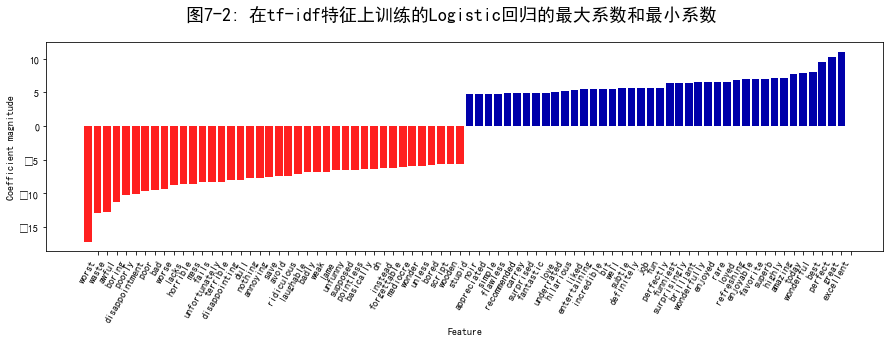

In [43]:
mglearn.tools.visualize_coefficients(grid.best_estimator_.named_steps["logisticregression"].coef_,feature_names,n_top_features=40)
plt.suptitle("图7-2: 在tf-idf特征上训练的Logistic回归的最大系数和最小系数",fontsize=18);

    左侧的负系数属于模型找到的表示负面评论的单词，而右侧的正系数属于模型找到的表示正面评论的单词。大多数单词都是非常直观的，比如"worst"（最差）、"waste"（浪费）、"disappointment"（ 失望） 和"laughable"（ 可笑） 都表示不好的电影评论， 而"excellent"（ 优秀）、"wonderful"（ 精彩）、"enjoyable"（ 令人愉悦） 和"refreshing"（耳目一新）则表示正面的电影评论。有些词的含义不那么明确，比如"bit"（一点）、"job"（工作）和"today"（今天），但它们可能是类似"good job"（做得不错）和“besttoday”（今日最佳）等短语的一部分。

# 7.7 多个单词的词袋(n元分词)

    使用词袋表示的主要缺点之一是完全舍弃了单词顺序。因此，“it’s bad, not good at all”（电影很差，一点也不好）和“it’s good, not bad at all”（电影很好，还不错）这两个字符串的词袋表示完全相同，尽管它们的含义相反。将“not”（不）放在单词前面，这只是上下文很重要的一个例子（可能是一个极端的例子）。幸运的是，使用词袋表示时有一种获取上下文的方法，就是不仅考虑单一词例的计数，而且还考虑相邻的两个或三个词例的计数。
    两个词例被称为二元分词（bigram），三个词例被称为三元分词（trigram），更一般的词例序列被称为n 元分词（n-gram）。我们可以通过改变CountVectorizer 或TfidfVectorizer的ngram_range 参数来改变作为特征的词例范围。ngram_range 参数是一个元组，包含要考虑的词例序列的最小长度和最大长度。下面是在之前用过的玩具数据上的一个示例：

In [44]:
print("bards_words:\n",bards_words)

bards_words:
 ['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']


In [46]:
#默认情况下，为每个长度最小为1 且最大为1 的词例序列创建一个特征——单个词例也被称为一元分词（unigram）：
cv = CountVectorizer(ngram_range=(1,1)).fit(bards_words)
print("Vocabulary size:",len(cv.vocabulary_))
print("Vocabulary:\n",cv.get_feature_names())

Vocabulary size: 13
Vocabulary:
 ['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man', 'the', 'think', 'to', 'wise']


In [47]:
#要想仅查看二元分词（即仅查看由两个相邻词例组成的序列），可以将ngram_range 设置为(2, 2)：
cv = CountVectorizer(ngram_range=(2,2)).fit(bards_words)
print("Vocabulary size:",len(cv.vocabulary_))
print("Vocabulary:\n",cv.get_feature_names())

Vocabulary size: 14
Vocabulary:
 ['be fool', 'but the', 'doth think', 'fool doth', 'he is', 'himself to', 'is wise', 'knows himself', 'man knows', 'the fool', 'the wise', 'think he', 'to be', 'wise man']


In [48]:
#使用更长的词例序列通常会得到更多的特征，也会得到更具体的特征。bard_words 的两个短语中没有相同的二元分词：
print("Transformed data (dense):\n",cv.transform(bards_words).toarray())

Transformed data (dense):
 [[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]


    对于大多数应用而言，最小的词例数量应该是1，因为单个单词通常包含丰富的含义。在大多数情况下，添加二元分词会有所帮助。添加更长的序列（一直到五元分词）也可能有所帮助，但这会导致特征数量的大大增加，也可能会导致过拟合，因为其中包含许多非常具体的特征。原则上来说，二元分词的数量是一元分词数量的平方，三元分词的数量是一元分词数量的三次方，从而导致非常大的特征空间。在实践中，更高的n 元分词在数据中的出现次数实际上更少，原因在于（英语）语言的结构，不过这个数字仍然很大。下面是在bards_words 上使用一元分词、二元分词和三元分词的结果：

In [49]:
cv = CountVectorizer(ngram_range=(1,3)).fit(bards_words)
print("Vocabulary size:",len(cv.vocabulary_))
print("Vocabulary:\n",cv.get_feature_names())

Vocabulary size: 39
Vocabulary:
 ['be', 'be fool', 'but', 'but the', 'but the wise', 'doth', 'doth think', 'doth think he', 'fool', 'fool doth', 'fool doth think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'knows', 'knows himself', 'knows himself to', 'man', 'man knows', 'man knows himself', 'the', 'the fool', 'the fool doth', 'the wise', 'the wise man', 'think', 'think he', 'think he is', 'to', 'to be', 'to be fool', 'wise', 'wise man', 'wise man knows']


In [54]:
#我们在IMDb 电影评论数据上尝试使用TfidfVectorizer，并利用网格搜索找出n 元分词的最佳设置：
pipe = make_pipeline(TfidfVectorizer(min_df=5),LogisticRegression())
# 运行网格搜索需要很长时间，因为网格相对较大，且包含三元分词
param_grid = {"logisticregression__C":[0.001,0.01,0.1,1,100],"tfidfvectorizer__ngram_range":[(1,1),(1,2),(1,3)]}
grid = GridSearchCV(pipe,param_grid,cv=5)
grid.fit(text_train,y_train)
print("Best cross-validation score:",grid.best_score_)
print("Best parameters:\n",grid.best_params_)

Best cross-validation score: 0.90644
Best parameters:
 {'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)}


    从结果中可以看出，我们添加了二元分词特征与三元分词特征之后，性能提高了一个百分点多一点。我们可以将交叉验证精度作为ngram_range 和C 参数的函数并用热图可视化(见图7-3)：

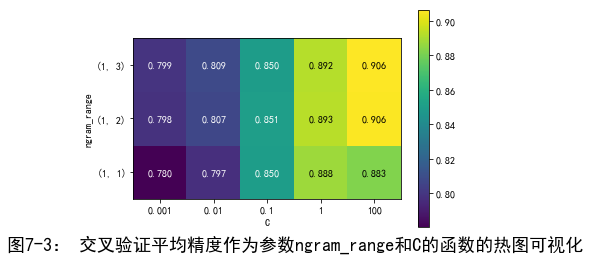

In [65]:
# 从网格搜索中提取分数
scores = grid.cv_results_["mean_test_score"].reshape(-1,3).T
heatmap = mglearn.tools.heatmap(
    scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
    xticklabels=param_grid['logisticregression__C'],
    yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)
plt.suptitle("图7-3： 交叉验证平均精度作为参数ngram_range和C的函数的热图可视化",y = 0.1,fontsize=18);

    从热图中可以看出，使用二元分词对性能有很大提高，而添加三元分词对精度只有很小贡献。为了更好地理解模型是如何改进的，我们可以将最佳模型的重要系数可视化，其中包含一元分词、二元分词和三元分词（见图7-4）：

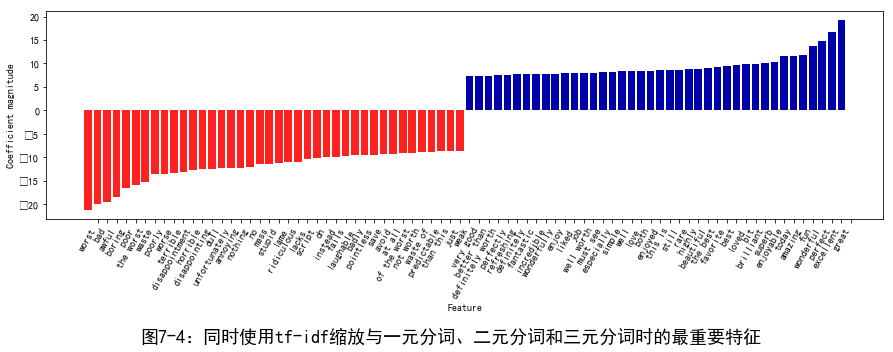

In [66]:
# 提取特征名称与系数
vect = grid.best_estimator_.named_steps["tfidfvectorizer"]
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps["logisticregression"].coef_
mglearn.tools.visualize_coefficients(coef,feature_names,n_top_features=40)
plt.suptitle("图7-4：同时使用tf-idf缩放与一元分词、二元分词和三元分词时的最重要特征",y = 0.0,fontsize=18);

    有几个特别有趣的特征，它们包含单词"worth"（值得），而这个词本身并没有出现在一元分词模型中："not worth"（不值得）表示负面评论，而"definitely worth"（绝对值得）和"well worth"（很值得）表示正面评论。这是上下文影响"worth" 一词含义的主要示例。
    接下来，我们只将三元分词可视化，以进一步深入了解这些特征有用的原因。许多有用的二元分词和三元分词都由常见的单词组成，这些单词本身可能没有什么信息量，比如"none of the"（没有一个）、"the only good"（唯一好的）、"on and on"（不停地）、"thisis one"（这是一部）、"of the most"（最）等短语中的单词。但是，与一元分词特征的重要性相比，这些特征的影响非常有限，正如图7-5 所示。

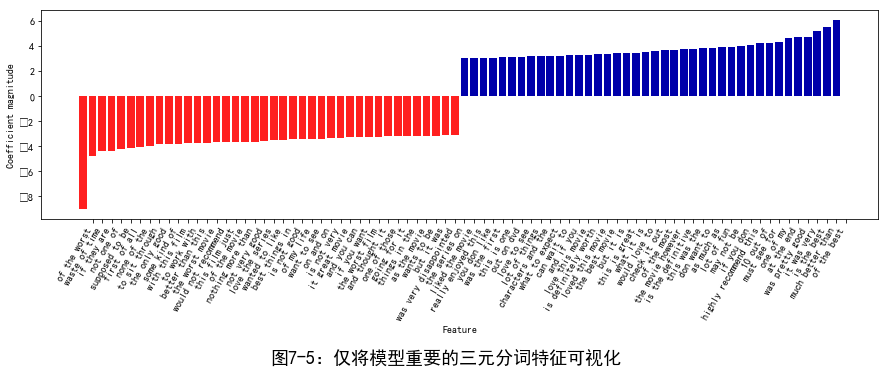

In [67]:
# 找到三元分词特征
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 3
# 仅将三元分词特征可视化
mglearn.tools.visualize_coefficients(coef.ravel()[mask],feature_names[mask],n_top_features=40)
plt.suptitle("图7-5：仅将模型重要的三元分词特征可视化",y = -0.06,fontsize=18);

# 7.8 高级分词、词干提取和词形还原
    如前所述，CountVectorizer 和TfidfVectorizer 中的特征提取相对简单，还有更为复杂的方法。在更加复杂的文本处理应用中，通常需要改进的步骤是词袋模型的第一步：分词（tokenization）。这一步骤为特征提取定义了一个单词是如何构成的。
    我们前面看到，词表中通常同时包含某些单词的单数形式和复数形式，比如"drawback"和"drawbacks"、"drawer" 和"drawers"、"drawing" 和"drawings"。对于词袋模型而言，"drawback" 和"drawbacks" 的语义非常接近，区分二者只会增加过拟合，并导致模型无法充分利用训练数据。同样我们还发现，词表中包含像"replace"、"replaced"、"replacement"、"replaces" 和"replacing" 这样的单词，它们都是动词“to replace”的不同动词形式或相关名词。与名词的单复数形式一样，将不同的动词形式及相关单词视为不同的词例，这不利于构建具有良好泛化性能的模型。
    这个问题可以通过用词干（word stem）表示每个单词来解决，这一方法涉及找出[ 或合并（conflate）] 所有具有相同词干的单词。如果使用基于规则的启发法来实现（比如删除常见的后缀），那么通常将其称为词干提取（stemming）。如果使用的是由已知单词形式组成的字典（明确的且经过人工验证的系统），并且考虑了单词在句子中的作用，那么这个过程被称为词形还原（lemmatization），单词的标准化形式被称为词元（lemma）。词干提取和词形还原这两种处理方法都是标准化（normalization）的形式之一，标准化是指尝试提取一个单词的某种标准形式。标准化的另一个有趣的例子是拼写校正，这种方法在实践中很有用，但超出了本书的范围。
    为了更好地理解标准化，我们来对比一种词干提取方法（Porter 词干提取器，一种广泛使用的启发法集合，从nltk 包导入）与spacy 包11 中实现的词形还原：

In [69]:
import spacy
import nltk

In [73]:
# 加载spacy的英语模型
en_nlp = spacy.load('en')
# 将nltk的Porter词干提取器实例化
stemmer = nltk.stem.PorterStemmer()
# 定义一个函数来对比spacy中的词形还原与nltk中的词干提取
def compare_normalization(doc):
    doc_spacy = en_nlp(doc)
    print("Lemmatization:")
    print([token.lemma_ for token in doc_spacy])
    print("Stemming:")
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

In [80]:
#我们将用一个句子来比较词形还原与Porter 词干提取器，以显示二者的一些区别
compare_normalization(u"Our meeting today was worse than yesterday,"
                      "I'm scared of meeting the clients tomorrow.")

Lemmatization:
['-PRON-', 'meeting', 'today', 'be', 'bad', 'than', 'yesterday', ',', "i'm", 'scar', 'of', 'meet', 'the', 'client', 'tomorrow', '.']
Stemming:
['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday', ',', "i'm", 'scare', 'of', 'meet', 'the', 'client', 'tomorrow', '.']


    词干提取总是局限于将单词简化成词干，因此"was" 变成了"wa"，而词形还原可以得到正确的动词基本词形"be"。同样，词形还原可以将"worse" 标准化为"bad"，而词干提取得到的是"wors"。另一个主要区别在于，词干提取将两处"meeting" 都简化为"meet"。利用词形还原，第一处"meeting" 被认为是名词，所以没有变化，而第二处"meeting" 被认为是动词，所以变为"meet"。一般来说，词形还原是一个比词干提取更复杂的过程，但用于机器学习的词例标准化时通常可以给出比词干提取更好的结果。
    虽然scikit-learn 没有实现这两种形式的标准化，但CountVectorizer 允许使用tokenizer参数来指定使用你自己的分词器将每个文档转换为词例列表。我们可以使用spacy 的词形还原了创建一个可调用对象，它接受一个字符串并生成一个词元列表：

In [ ]:
import re
regexp = re.compile('(?u)\\b\\w\\w+\\b')
en_nlp = spacy.load('en')
old_tokenizer = en_nlp.tokenizer
#en_nlp.tokenizer = lambda string:old_tokenizer.tokens_from_list(regexp.findall(string))
def custom_tokenizer(document):
    doc_spacy = en_nlp(document)   #,entity=False,parse=False
    return [token.lemma_ for token in doc_spacy]
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer,min_df=5)

In [92]:
x_train_lemma = lemma_vect.fit_transform(text_train)
print("x_train_lemma.shape:",x_train_lemma.shape)
vect = CountVectorizer(min_df=5).fit(text_train)
print("x_train.shape:",x_train.shape)

x_train_lemma.shape: (25000, 21821)
x_train.shape: (25000, 27271)


    从输出中可以看出，词形还原将特征数量从27 271 个（标准的CountVectorizer 处理过程）减少到21 821 个。词形还原可以被看作是一种正则化，因为它合并了某些特征。因此我们预计，数据集很小时词形还原对性能的提升最大。为了说明词形还原的作用，我们将使用StratifiedShuffleSplit 做交叉验证，仅使用1% 的数据作为训练数据，其余数据作为测试数据：

In [93]:
from sklearn.model_selection import StratifiedShuffleSplit
param_grid ={'C':[0.001,0.01,0.1,1,10]}
cv = StratifiedShuffleSplit(n_splits=5,test_size=0.99,train_size=0.01,random_state=0) 
grid = GridSearchCV(LogisticRegression(),param_grid,cv=cv)
grid.fit(x_train,y_train)
print("Best cross-validation score （standard CountVectorizer): {:.3f}".format(grid.best_score_))
grid.fit(x_train_lemma,y_train)
print("BEst cross-validation score (lemmatization):{:.3f}".format(grid.best_score_))

Best cross-validation score （standard CountVectorizer): 0.772
BEst cross-validation score (lemmatization):0.722


    在这个例子中，词形还原对性能有较小的提高。与许多特征提取技术一样，其结果因数据集的不同而不同。词形还原与词干提取有时有助于构建更好的模型（或至少是更简洁的模型），所以我们建议你，在特定任务中努力提升最后一点性能时可以尝试这些技术。

# 7.9 主题建模与文档聚类 
    常用于文本数据的一种特殊技术是主题建模（topic modeling），这是描述将每个文档分配给一个或多个主题的任务（通常是无监督的）的概括性术语。这方面一个很好的例子是新闻数据，它们可以被分为“政治”“体育”“金融”等主题。如果为每个文档分配一个主题，那么这是一个文档聚类任务。如果每个文档可以有多个主题，那么这个任务是一种成分分解。每个成分对应于一个主题，文档表示中的成分系数告诉我们这个文档与该主题的相关性强弱。通常来说，人们在谈论主题建模时，他们指的是一种叫作隐含狄利克雷分布（Latent Dirichlet Allocation，LDA）的特定分解方法。
       
### 隐含狄利克雷分布 
    从直观上来看，LDA 模型试图找出频繁共同出现的单词群组（即主题）。LDA 还要求，每个文档可以被理解为主题子集的“混合”。重要的是要理解，机器学习模型所谓的“主题”可能不是我们通常在日常对话中所说的主题，而是更类似于PCA 或NMF所提取的成分，它可能具有语义，也可能没有。即使LDA“主题”具有语义，它可能也不是我们通常所说的主题。回到新闻文章的例子，我们可能有许多关于体育、政治和金融的文章，由两位作者所写。在一篇政治文章中，我们预计可能会看到“州长”“投票”“党派”等词语，而在一篇体育文章中，我们预计可能会看到类似“队伍”“得分”和“赛季”之类的词语。这两组词语可能会同时出现，而例如“队伍”和“州长”就不太可能同时出现。但是，这并不是我们预计可能同时出现的唯一的单词群组。这两位记者可能偏爱不同的短语或者选择不同的单词。可能其中一人喜欢使用“划界”（demarcate）这个词，而另一人喜欢使用“两极分化”（polarize）这个词。其他“主题”可能是“记者A 常用的词语”和“记者B 常用的词语”，虽然这并不是通常意义上的主题。
    我们将LDA 应用于电影评论数据集，来看一下它在实践中的效果。对于无监督的文本文档模型，通常最好删除非常常见的单词，否则它们可能会支配分析过程。我们将删除至少在15% 的文档中出现过的单词，并在删除前15% 之后，将词袋模型限定为最常见的10 000 个单词：

In [95]:
vect = CountVectorizer(max_features=10000,max_df=.15)
x = vect.fit_transform(text_train)

In [97]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10,learning_method="batch",max_iter=25,random_state=0)
document_topics = lda.fit_transform(x)

In [98]:
lda.components_.shape

(10, 10000)

In [99]:
sorting = np.argsort(lda.components_,axis=1)[:,::-1]
feature_names = np.array(vect.get_feature_names())

In [100]:
mglearn.tools.print_topics(topics=range(10),feature_names=feature_names,sorting=sorting,topics_per_chunk=5,n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
between       war           funny         show          didn          
young         world         worst         series        saw           
family        us            comedy        episode       am            
real          our           thing         tv            thought       
performance   american      guy           episodes      years         
beautiful     documentary   re            shows         book          
work          history       stupid        season        watched       
each          new           actually      new           now           
both          own           nothing       television    dvd           
director      point         want          years         got           


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
horr

    我们将学习一个包含10 个主题的主题模型，它包含的主题个数很少，我们可以查看所有主题。与NMF 中的分量类似，主题没有内在的顺序，而改变主题数量将会改变所有主题。我们将使用"batch" 学习方法，它比默认方法（"online"）稍慢，但通常会给出更好的结果。我们还将增大max_iter，这样会得到更好的模型。
    为了更好地理解不同主题的含义，我们将查看每个主题中最重要的单词。print_topics 函数为这些特征提供了良好的格式。
    从重要的单词来看，主题1 似乎是关于历史和战争的电影，主题2 可能是关于糟糕的喜剧，主题3 可能是关于电视连续剧，主题4 可能提取了一些非常常见的单词，而主题6 似乎是关于儿童电影，主题8 似乎提取了与获奖相关的评论。仅使用10 个主题，每个主题都需要非常宽泛，才能共同涵盖我们的数据集中所有不同类型的评论。
    
    接下来，我们将学习另一个模型，这次包含100 个主题。使用更多的主题，将使得分析过程更加困难，但更可能使主题专门针对于某个有趣的数据子集：

In [101]:
lda100 = LatentDirichletAllocation(n_components=100,learning_method="batch",max_iter=25,random_state=0)
document_topics100 = lda100.fit_transform(x)

In [103]:
topics = np.array([7,16,24,25,28,36,37,45,51,53,54,63,89,97])
sorting = np.argsort(lda100.components_,axis=1)[:,::-1]
mglearn.tools.print_topics(topics=topics,feature_names=feature_names,sorting=sorting,topics_per_chunk=7,n_words=20)

topic 7       topic 16      topic 24      topic 25      topic 28      topic 36      topic 37      
--------      --------      --------      --------      --------      --------      --------      
thriller      worst         german        car           beautiful     performance   excellent     
suspense      awful         hitler        gets          young         role          highly        
horror        boring        nazi          guy           old           actor         amazing       
atmosphere    horrible      midnight      around        romantic      cast          wonderful     
mystery       stupid        joe           down          between       play          truly         
house         thing         germany       kill          romance       actors        superb        
director      terrible      years         goes          wonderful     performances  actors        
quite         script        history       killed        heart         played        brilliant     
bit       

    这次我们提取的主题似乎更加具体，不过很多都难以解读。主题7 似乎是关于恐怖电影和惊悚片，主题16 和54 似乎是关于不好的评论，而主题63 似乎主要是关于喜剧的正面评论。如果想要利用发现的主题做出进一步的推断，那么我们应该查看分配给这些主题的文档，以验证我们通过查看每个主题排名最靠前的单词所得到的直觉。例如，主题45 似乎是关于音乐的。
    我们来查看哪些评论被分配给了这个主题：

In [104]:
music = np.argsort(document_topics100[:,45])[::-1]
for i in music[:10]:
    print(b".".join(text_train[i].split(b".")[:2])+b".\n")

b'I love this movie and never get tired of watching. The music in it is great.\n'
b"I enjoyed Still Crazy more than any film I have seen in years. A successful band from the 70's decide to give it another try.\n"
b'Hollywood Hotel was the last movie musical that Busby Berkeley directed for Warner Bros. His directing style had changed or evolved to the point that this film does not contain his signature overhead shots or huge production numbers with thousands of extras.\n'
b"What happens to washed up rock-n-roll stars in the late 1990's? They launch a comeback / reunion tour. At least, that's what the members of Strange Fruit, a (fictional) 70's stadium rock group do.\n"
b'As a big-time Prince fan of the last three to four years, I really can\'t believe I\'ve only just got round to watching "Purple Rain". The brand new 2-disc anniversary Special Edition led me to buy it.\n'
b"This film is worth seeing alone for Jared Harris' outstanding portrayal of John Lennon. It doesn't matter that H

    可以看出，这个主题涵盖许多以音乐为主的评论，从音乐剧到传记电影，再到最后    一条评论中难以归类的类型。查看主题还有一种有趣的方法，就是通过对所有评论的document_topics 进行求和来查看每个主题所获得的整体权重。我们用最常见的两个单词为每个主题命名。图7-6 给出了学到的主题权重：

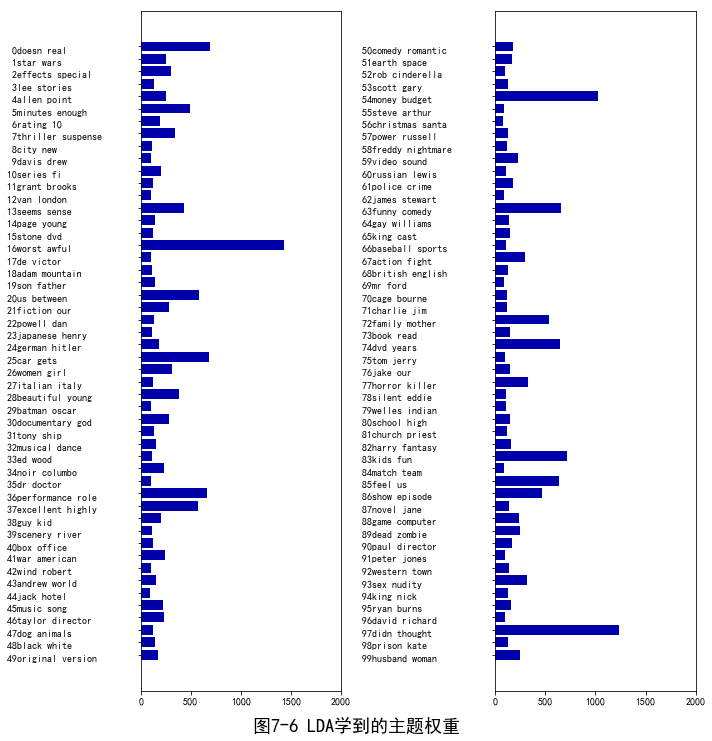

In [111]:
fig,ax = plt.subplots(1,2,figsize=(10,10))
topic_names = ["{:>2}".format(i)+" ".join(words)  for i,words in enumerate(feature_names[sorting[:,:2]])]
for col in [0,1]:
    start = col *50
    end = (col +1)*50
    ax[col].barh(np.arange(50),np.sum(document_topics100,axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end],ha='left',va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0,2000)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()
plt.suptitle("图7-6 LDA学到的主题权重",y=0.0,fontsize=18);

    最重要的主题是主题97，它可能主要包含停用词，可能还有一些稍负面的单词；主题16明显是有关负面评论的；然后是一些特定类型的主题与主题36 和37，这二者似乎都包含表示赞美的单词。
    除了几个不太具体的主题之外，LDA 似乎主要发现了两种主题：特定类型的主题与特定评分的主题。这是一个有趣的发现，因为大部分评论都由一些与电影相关的评论与一些证明或强调评分的评论组成。
    在没有标签的情况下（或者像本章的例子这样，即使有标签的情况下），像LDA 这样的主题模型是理解大型文本语料库的有趣方法。不过LDA 算法是随机的，改变random_state参数可能会得到完全不同的结果。虽然找到主题可能很有用，但对于从无监督模型中得出的任何结论都应该持保留态度，我们建议通过查看特定主题中的文档来验证你的直觉。LDA.transform 方法生成的主题有时也可以用于监督学习的紧凑表示。当训练样例很少时，这一方法特别有用。
    
# 7.10 小结与展望

    本章讨论了处理文本[ 也叫自然语言处理（NLP）] 的基础知识，还给出了一个对电影评论进行分类的示例应用。如果你想要尝试处理文本数据，那么这里讨论的工具应该是很好的出发点。特别是对于文本分类任务，比如检测垃圾邮件和欺诈或者情感分析，词袋模型提供了一种简单而又强大的解决方案。正如机器学习中常见的情况，数据表示是NLP 应用的关键，检查所提取的词例和n 元分词有助于深入理解建模过程。在文本处理应用中，对于监督任务与无监督任务而言，通常都可以用有意义的方式对模型进行内省，正如我们在本章所见。在实践中使用基于NLP 的方法时，你应该充分利用这一能力。
    自然语言和文本处理是一个很大的研究领域，讨论其高级方法的细节已经远远超出了本书范围。如果你想学习更多内容，我们推荐阅读Steven Bird、Ewan Klein 和EdwardLoper 合著的Natural Language Processing with Python 一书，其中给出了NLP 的概述，并介绍了nltk 这个用于NLP 的Python 库。另一本很好且概念性更强的书是Christopher Manning、PrabhakarRaghavan 和Hinrich Schuütze 合著的标准参考，Introduction to Information Retrieval，其中介绍了信息检索、NLP 和机器学习中的基本算法。这两本书都有可以免费访问的在线版本。如前所述，CountVectorizer 类和TfidfVectorizer 类仅实现了相对简单的文本处理方法。对于更高级的文本处理方法，我们推荐使用Python 包spacy（一个相对较新的包，但非常高效，且设计良好）、nltk（一个非常完善且完整的库，但有些过时）和gensim（着重于主题建模的NLP 包）。
    近年来，在文本处理方面有许多非常令人激动的新进展，这些内容都超出了本书的范围，并且都和神经网络有关。第一个进展是使用连续向量表示，也叫作词向量（word vector）或分布式词表示（distributed word representation）， 它在word2vec 库中实现。ThomasMikolov（ 等人的原始论文）“Distributed Representations of Words and Phrases and TheirCompo sitionality”是对这一主题的很好介绍。对于这篇论文及其后续所讨论的技术，spacy 和gensim 都提供了相应的功能。
    近年来，NLP 还有另一个研究方向不断升温，就是使用递归神经网络（recurrent neuralnetwork，RNN）进行文本处理。与只能分配类别标签的分类模型相比，RNN 是一种特别强大的神经网络，可以生成同样是文本的输出。能够生成文本作为输出，使得RNN非常适合自动翻译和摘要。Ilya Suskever、Oriol Vinyals 和Quoc Le 的一篇技术性相对较强的文章“Sequence to Sequence Learning with Neural Networks”对这一主题进行了介绍。在TensorFlow 网站上可以找到使用tensorflow 框架的更为实用的教程。 
    